In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import librosa
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from glob import glob

# 1. U-Net Model with proper size maintenance
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(1, 32)
        self.pool1 = nn.MaxPool1d(2)
        self.enc2 = self.conv_block(32, 64)
        self.pool2 = nn.MaxPool1d(2)
        self.enc3 = self.conv_block(64, 128)
        self.pool3 = nn.MaxPool1d(2)
        self.enc4 = self.conv_block(128, 256)
        self.pool4 = nn.MaxPool1d(2)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Decoder
        self.up1 = nn.ConvTranspose1d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(512, 256)
        self.up2 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.up3 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(128, 64)
        self.up4 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(64, 32)

        # Output layer
        self.out = nn.Conv1d(32, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)    # [B, 32, 16000]
        p1 = self.pool1(e1)  # [B, 32, 8000]
        e2 = self.enc2(p1)   # [B, 64, 8000]
        p2 = self.pool2(e2)  # [B, 64, 4000]
        e3 = self.enc3(p2)   # [B, 128, 4000]
        p3 = self.pool3(e3)  # [B, 128, 2000]
        e4 = self.enc4(p3)   # [B, 256, 2000]
        p4 = self.pool4(e4)  # [B, 256, 1000]

        # Bottleneck
        bn = self.bottleneck(p4)  # [B, 512, 1000]

        # Decoder
        d1 = self.up1(bn)        # [B, 256, 2000]
        d1 = torch.cat([d1, e4], dim=1)  # [B, 512, 2000]
        d1 = self.dec1(d1)       # [B, 256, 2000]

        d2 = self.up2(d1)        # [B, 128, 4000]
        d2 = torch.cat([d2, e3], dim=1)  # [B, 256, 4000]
        d2 = self.dec2(d2)       # [B, 128, 4000]

        d3 = self.up3(d2)        # [B, 64, 8000]
        d3 = torch.cat([d3, e2], dim=1)  # [B, 128, 8000]
        d3 = self.dec3(d3)       # [B, 64, 8000]

        d4 = self.up4(d3)        # [B, 32, 16000]
        d4 = torch.cat([d4, e1], dim=1)  # [B, 64, 16000]
        d4 = self.dec4(d4)       # [B, 32, 16000]

        return self.out(d4)       # [B, 1, 16000]

# 2. Dataset Class
class PairedAudioDataset(Dataset):
    def __init__(self, clean_dir, noisy_dir, sr=16000, duration=1.0):
        self.sr = sr
        self.duration = duration
        self.length = int(sr * duration)

        self.clean_files = sorted(glob(os.path.join(clean_dir, '*.wav')))
        self.noisy_files = sorted(glob(os.path.join(noisy_dir, '*.wav')))

        assert len(self.clean_files) == len(self.noisy_files), "File count mismatch"

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        clean, _ = librosa.load(self.clean_files[idx], sr=self.sr)
        noisy, _ = librosa.load(self.noisy_files[idx], sr=self.sr)

        if len(clean) > self.length:
            clean = clean[:self.length]
            noisy = noisy[:self.length]
        else:
            padding = self.length - len(clean)
            clean = np.pad(clean, (0, padding))
            noisy = np.pad(noisy, (0, padding))

        max_val = max(np.max(np.abs(noisy)), np.max(np.abs(clean)))
        noisy = noisy / (max_val + 1e-6)
        clean = clean / (max_val + 1e-6)

        return (torch.FloatTensor(noisy).unsqueeze(0),
                torch.FloatTensor(clean).unsqueeze(0))

# 3. Training Function
import torch
import matplotlib.pyplot as plt
import numpy as np

def compute_snr(clean, denoised):
    """Compute Signal-to-Noise Ratio (SNR) improvement."""
    noise = clean - denoised
    snr = 10 * torch.log10(torch.sum(clean ** 2) / (torch.sum(noise ** 2) + 1e-6))
    return snr.item()

def train(model, dataset, epochs=100, lr=0.001, batch_size=16):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    loss_history = []
    snr_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_snr = 0.0
        total_samples = 0

        for noisy, clean in dataloader:
            noisy = noisy.to(device)
            clean = clean.to(device)

            outputs = model(noisy)
            loss = criterion(outputs, clean)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute SNR improvement
            snr = compute_snr(clean, outputs)
            running_snr += snr
            total_samples += 1

        avg_loss = running_loss / len(dataloader)
        avg_snr = running_snr / total_samples

        loss_history.append(avg_loss)
        snr_history.append(avg_snr)

        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, SNR: {avg_snr:.2f} dB')

    return model, loss_history, snr_history


# 4. Inference Function
def denoise_audio(model, noisy_audio, sr=16000, chunk_size=16000):
    device = next(model.parameters()).device
    model.eval()

    orig_length = len(noisy_audio)
    padding = (chunk_size - (orig_length % chunk_size)) % chunk_size
    noisy_audio = np.pad(noisy_audio, (0, padding))

    denoised = []
    for i in range(0, len(noisy_audio), chunk_size):
        chunk = noisy_audio[i:i+chunk_size]
        with torch.no_grad():
            chunk_tensor = torch.FloatTensor(chunk).unsqueeze(0).unsqueeze(0).to(device)
            denoised_chunk = model(chunk_tensor).squeeze().cpu().numpy()
            denoised.append(denoised_chunk)

    return np.concatenate(denoised)[:orig_length]




In [ ]:
if __name__ == "__main__":
    # Paths to your folders
    clean_dir = "/content/drive/MyDrive/Colab Notebooks/Audio Denoising/Dataset/clean/0dB/"
    noisy_dir = "/content/drive/MyDrive/Colab Notebooks/Audio Denoising/Dataset/Noisy/5dB/"

    # 1. Create dataset
    dataset = PairedAudioDataset(clean_dir, noisy_dir, duration=1.0)

    # 2. Initialize model and verify sizes
    model = UNet()
    test_input = torch.randn(1, 1, 16000)
    test_output = model(test_input)
    print(f"Input shape: {test_input.shape}, Output shape: {test_output.shape}")
    assert test_input.shape == test_output.shape, "Model doesn't preserve input size!"

    # 3. Train model
    trained_model, loss_history, snr_history = train(model, dataset, epochs=100)


Input shape: torch.Size([1, 1, 16000]), Output shape: torch.Size([1, 1, 16000])
Epoch 1, Loss: 0.0916, SNR: -6.58 dB
Epoch 2, Loss: 0.0253, SNR: -1.14 dB
Epoch 3, Loss: 0.0121, SNR: 1.90 dB
Epoch 4, Loss: 0.0105, SNR: 2.54 dB
Epoch 5, Loss: 0.0073, SNR: 4.10 dB
Epoch 6, Loss: 0.0061, SNR: 4.88 dB
Epoch 7, Loss: 0.0057, SNR: 5.16 dB
Epoch 8, Loss: 0.0051, SNR: 5.62 dB


KeyboardInterrupt: 

In [ ]:
import math
import os

In [ ]:
    # 4. Test denoising
test_file = os.path.join(noisy_dir, os.listdir(noisy_dir)[31])
noisy_audio, sr = librosa.load(test_file, sr=16000)
denoised = denoise_audio(trained_model, noisy_audio, sr)


    # Save results using soundfile instead of librosa.output
import soundfile as sf
sf.write('denoised_sample.wav', denoised, sr)

from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff=100, fs=16000, order=1):
  b, a = butter(order, cutoff/(0.6*fs), btype='low', analog=False)
  return filtfilt(b, a, data)

filtered_output = butter_lowpass_filter(denoised)
print(type(filtered_output))



<ipython-input-9-89d4674e0fc2>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  noisy_audio, sr = librosa.load(test_file, sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


<class 'numpy.ndarray'>


In [ ]:
from IPython.display import Audio, display

# Play original noisy audio
print("Noisy Audio:")
display(Audio(noisy_audio, rate=sr))

# Play denoised audio
print("Denoised Audio:")
display(Audio(denoised, rate=sr))

Noisy Audio:


Denoised Audio:


[0.14759443 0.14284644 0.13819894 ... 0.         0.         0.        ]


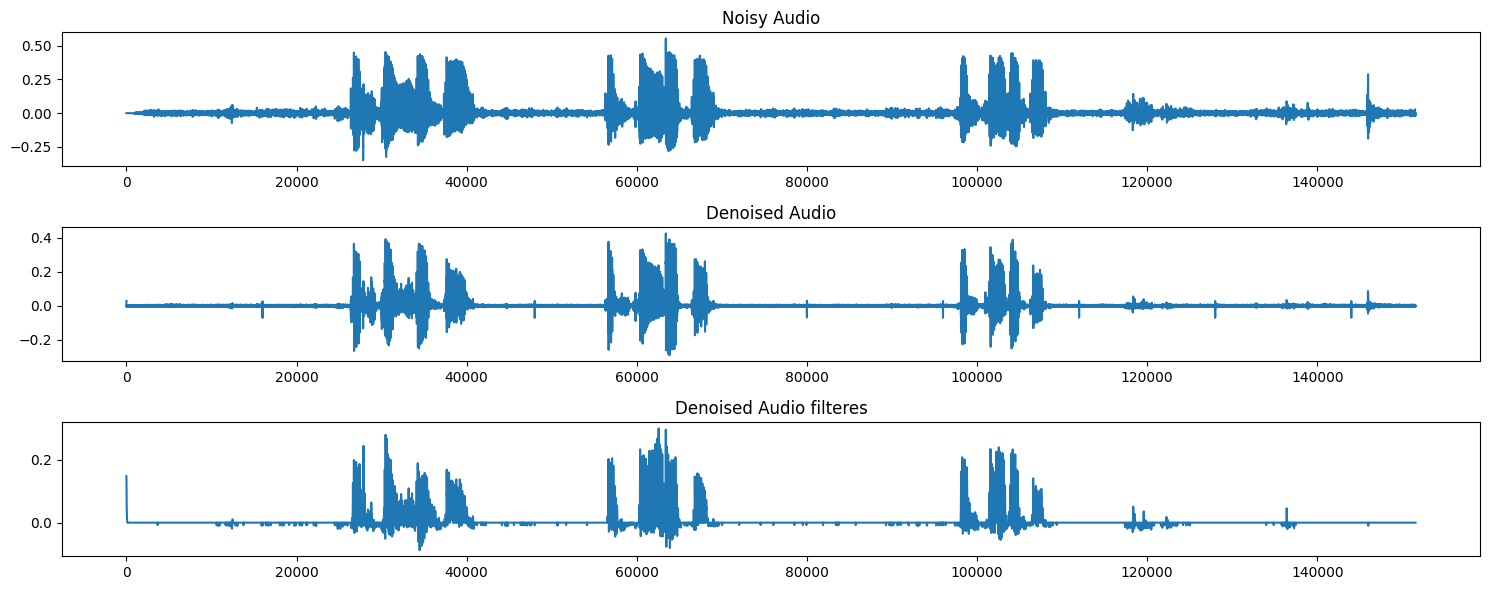

In [ ]:
filtered = np.array([])
for i in filtered_output:
  if (i>0.0015):
    filtered = np.append(filtered, i*5)
  elif i<-0.0015:
    # print(2)
    filtered = np.append(filtered, i*5)
  else:
    # print(3)
    filtered = np.append(filtered, 0)

print(filtered)
plt.figure(figsize=(15, 6))
plt.subplot(3, 1, 1)
plt.title('Noisy Audio')
plt.plot(noisy_audio)
plt.subplot(3, 1, 2)
plt.title('Denoised Audio')
plt.plot(denoised)
plt.savefig('comparison.png')
plt.subplot(3, 1, 3)
plt.title('Denoised Audio filteres')
plt.plot(filtered)
plt.tight_layout()
plt.savefig('comparison.png')
plt.show()

In [ ]:
from IPython.display import Audio, display

# Play original noisy audio
print("Noisy Audio:")
display(Audio(noisy_audio, rate=sr))

# Play denoised audio
print("Denoised Audio:")
display(Audio(filtered_output, rate=sr))

Noisy Audio:


Denoised Audio:


In [ ]:
!pip install torchsummary  # Install if needed
from torchsummary import summary

# Initialize your model
model = UNet().to('cuda' if torch.cuda.is_available() else 'cpu')

# Print summary (input shape: [channels, length])
summary(model, input_size=(1, 16000))  # For 1D audio input

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 32, 16000]             128
       BatchNorm1d-2            [-1, 32, 16000]              64
         LeakyReLU-3            [-1, 32, 16000]               0
            Conv1d-4            [-1, 32, 16000]           3,104
       BatchNorm1d-5            [-1, 32, 16000]              64
         LeakyReLU-6            [-1, 32, 16000]               0
         MaxPool1d-7             [-1, 32, 8000]               0
            Conv1d-8             [-1, 64, 8000]           6,208
       BatchNorm1d-9             [-1, 64, 8000]             128
        LeakyReLU-10             [-1, 64, 8000]               0
           Conv1d-11             [-1, 64, 8000]          12,352
      BatchNorm1d-12             [-1, 64, 8000]             128
        LeakyReLU-13             [-1, 64, 8000]               0
        MaxPool1d-14             [-1, 6

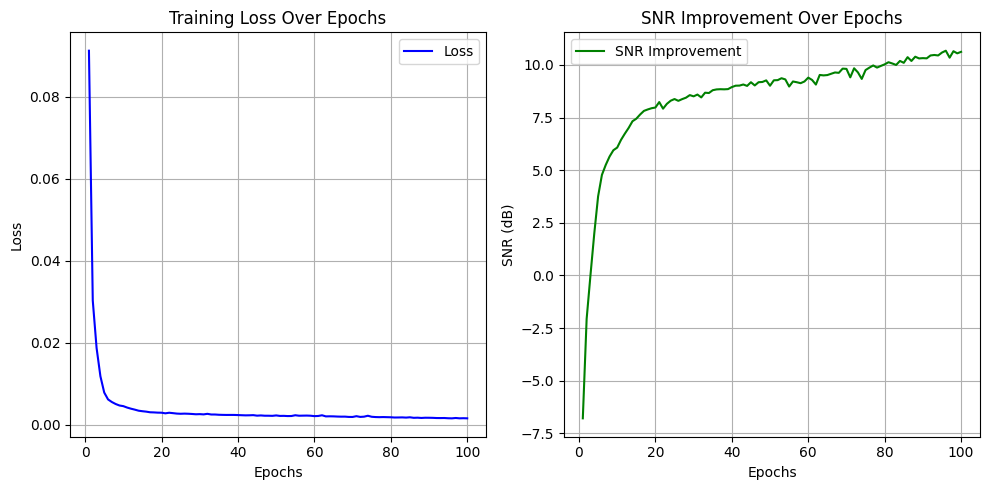

In [ ]:
plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()

# Plot SNR Improvement
plt.subplot(1, 2, 2)
plt.plot(range(1, len(snr_history) + 1), snr_history, label='SNR Improvement', color='green')
plt.xlabel('Epochs')
plt.ylabel('SNR (dB)')
plt.title('SNR Improvement Over Epochs')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
